<a href="https://colab.research.google.com/github/Rendy3001/BDS/blob/main/LLM_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Opinion Leader Detection Network
The purpose is to identify central figures or organizations, especially those consistently associated with high sentiment, indicating influence or trustworthiness.

By analyzing the frequency and sentiment of mentions for key companies or opinion leaders, we will construct a network where central nodes represent opinion leaders or main topics of discussion.


In [14]:
# Installing required packages
!pip install ollama pandas networkx matplotlib tqdm -q

In [15]:
# Installing Ollama
!sudo apt-get install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pciutils is already the newest version (1:3.7.0-6).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [16]:
import os
import threading
import subprocess

def start_ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=start_ollama)
ollama_thread.start()

In [17]:
!ollama pull qwen2.5

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest 
pulling 2bada8a74506... 100% ▕▏ 4.7 GB                         
pulling 66b9ea09bd5b... 100% ▕▏   68 B                         
pulling eb4402837c78... 100% ▕▏ 1.5 KB                         
pulling 832dd9e00a68... 100% ▕▏  11 KB                         
pulling 2f15b3218f05... 100% ▕▏  487 B                         
verifying sha256 digest 
writing manifest 
success 


In [18]:
#Importing necessary components
import json
import ollama
import networkx as nx
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

#Defining an extraction schema, where the relationships will include:



*   "from": "Entity Name"
*   "to": "Article Title"
*   "type": "mention"
*   "sentiment": "sentiment_score"

In [19]:
SYSTEM_PROMPT = """Extract relationships between companies or thought leaders and the articles they are mentioned in. Focus on capturing the sentiment associated with each mention and the frequency of mentions across the articles. Provide the output in this JSON format:
{
 "edges": [
   {"from": "Entity Name", "to": "Article Title", "type": "mention", "sentiment": "sentiment_score"}
 ]
}
The "type" field should always be "mention".

The "sentiment" field should represent the sentiment score of the article where the entity is mentioned, which can range from -1 (negative sentiment) to 1 (positive sentiment).

Ensure that the output is a valid JSON object with an 'edges' array, even if it is empty. The output must be in English.

Examples based on the input articles:
1. {"from": "Google", "to": "New AI Feature Summarizes Google Meet Conversations", "type": "mention", "sentiment": 0.3}
2. {"from": "TikTok", "to": "TikTok Lite Removes Reward Feature in EU", "type": "mention", "sentiment": 0.1}
3. {"from": "Apple", "to": "AI Gadgets: Setting Expectations", "type": "mention", "sentiment": -0.2}
4. {"from": "Adobe", "to": "AI Tools for Content Creation", "type": "mention", "sentiment": 0.5}
5. {"from": "Microsoft", "to": "AI Tools for Business Productivity", "type": "mention", "sentiment": 0.4}
"""


In [20]:
def extract_relationships(article):
    prompt = f"""
    Extract key relationships between companies or thought leaders and the articles they are mentioned in from this text:
    Title: {article['title']}
    Text: {article['text']}

    Focus on capturing the sentiment associated with each mention and the frequency of mentions across the articles.
    Provide the output in the following JSON format:
    {{
     "edges": [
       {{"from": "Entity Name", "to": "Article Title", "type": "mention", "sentiment": "sentiment_score"}}
     ]
    }}

    The "type" field should always be "mention". The "sentiment" field should represent the sentiment score of the article where the entity is mentioned, ranging from -1 (negative sentiment) to 1 (positive sentiment).
    """

    response = ollama.chat(
        model='qwen2.5',
        messages=[
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': prompt},
        ],
        format='json',
        options={"temperature": 0.1}
    )

    return response['message']['content']


In [21]:
!wget https://raw.githubusercontent.com/aaubs/ds-master/refs/heads/main/data/paraphrased_articles.jsonl

--2024-10-31 10:45:26--  https://raw.githubusercontent.com/aaubs/ds-master/refs/heads/main/data/paraphrased_articles.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2620931 (2.5M) [text/plain]
Saving to: ‘paraphrased_articles.jsonl.1’

paraphrased_article 100%[===================>]   2.50M  --.-KB/s    in 0.05s   

2024-10-31 10:45:26 (53.4 MB/s) - ‘paraphrased_articles.jsonl.1’ saved [2620931/2620931]



In [22]:
#Reading input articles
with open('paraphrased_articles.jsonl', 'r', encoding='utf-8') as f:
    articles = [json.loads(line) for line in f][:20]  #Loading first 20 articles

#Processing articles
results = []
for article in tqdm(articles, desc="Processing articles"):
    try:
        extracted_data = json.loads(extract_relationships(article))  #Calling extraction function
        results.append({
            'title': article['title'],
            'extracted_data': extracted_data  #Storing extracted relationships
        })
    except json.JSONDecodeError as e:
        print(f"Error processing article '{article['title']}': {str(e)}")
    except Exception as e:
        print(f"Unexpected error processing article '{article['title']}': {str(e)}")

#Displaying first 5 results
for i, result in enumerate(results[:5]):
    print(f"Article {i+1}: {result['title']}")
    print(json.dumps(result['extracted_data'], indent=2))
    print("\n" + "="*20 + "\n")

#Saving all results
with open('opinion_leader_relationships.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print(f"Results saved to opinion_leader_relationships.json")


Processing articles:   0%|          | 0/20 [00:00<?, ?it/s]

Article 1: New AI Feature Summarizes Google Meet Conversations
{
  "edges": [
    {
      "from": "Google",
      "to": "New AI Feature Summarizes Google Meet Conversations",
      "type": "mention",
      "sentiment": 0.6
    }
  ]
}


Article 2: AI Gadgets: Setting Expectations
{
  "edges": [
    {
      "from": "Rabbit R1",
      "to": "AI Gadgets: Setting Expectations",
      "type": "mention",
      "sentiment": -0.8
    },
    {
      "from": "Humane AI Pin",
      "to": "AI Gadgets: Setting Expectations",
      "type": "mention",
      "sentiment": -0.8
    },
    {
      "from": "Google",
      "to": "AI Gadgets: Setting Expectations",
      "type": "mention",
      "sentiment": 0.2
    }
  ]
}


Article 3: TikTok Lite Removes Reward Feature in EU
{
  "edges": [
    {
      "from": "TikTok",
      "to": "TikTok Lite Removes Reward Feature in EU",
      "type": "mention",
      "sentiment": 0.1
    }
  ]
}


Article 4: US Investigates Chinese Connected Cars; Alibaba Cloud Cuts P

#Network analysis

In [23]:
#Creating a bipartite graph from the extracted relationships
B = nx.Graph()
companies = set()
articles = set()

print("Building bipartite graph...")
for result in tqdm(results, desc="Processing Results"):
    for edge in result['extracted_data'].get('edges', []):
        company = edge.get('from')
        article_title = edge.get('to')
        if not company or not article_title:
            continue
        companies.add(company)
        articles.add(article_title)
        B.add_edge(company, article_title)  #Connecting company to article title

print(f"\nNumber of companies: {len(companies)}")
print(f"Number of articles: {len(articles)}")
print(f"Number of edges in the bipartite graph: {B.number_of_edges()}")

#Projecting onto the company layer using weighted_projected_graph
print("\nProjecting bipartite graph onto company layer...")
company_graph = nx.bipartite.weighted_projected_graph(B, companies)
print(f"Number of nodes in company graph: {company_graph.number_of_nodes()}")
print(f"Number of edges in company graph: {company_graph.number_of_edges()}")


Building bipartite graph...


Processing Results:   0%|          | 0/20 [00:00<?, ?it/s]


Number of companies: 46
Number of articles: 20
Number of edges in the bipartite graph: 55

Projecting bipartite graph onto company layer...
Number of nodes in company graph: 46
Number of edges in company graph: 98


#Edge trimming and graph

In [24]:
def trim_edges(graph, percentile=20):
    """
    Removes edges from the graph that have weights below the specified percentile.

    Parameters:
    - graph (networkx.Graph): The input graph with weighted edges.
    - percentile (float): The percentile threshold below which edges will be removed.

    Returns:
    - networkx.Graph: The trimmed graph with low-weight edges removed.
    """
    #Checking if the graph has edges with weights
    if not graph.edges(data=True):
        print("The graph has no edges to trim.")
        return graph

    #Extracting edge weights for threshold calculation
    weights = [data['weight'] for _, _, data in graph.edges(data=True)]
    threshold = np.percentile(weights, percentile)
    print(f"Trimming edges with weights below the {percentile}th percentile (threshold: {threshold:.4f})")

    #Creating new trimmed graph
    trimmed_graph = nx.Graph()

    #Adding edges above the weight threshold to the trimmed graph
    for u, v, data in graph.edges(data=True):
        if data['weight'] >= threshold:
            trimmed_graph.add_edge(u, v, **data)

    #Saving all original nodes
    trimmed_graph.add_nodes_from(graph.nodes(data=True))
    return trimmed_graph


In [25]:
#Triming edges with lowest weights before plotting
percentile = 10
print("\nTrimming low-weight edges...")
trimmed_company_graph = trim_edges(company_graph, percentile=percentile)
print(f"Number of nodes after trimming: {trimmed_company_graph.number_of_nodes()}")
print(f"Number of edges after trimming: {trimmed_company_graph.number_of_edges()}")

#Calculating centralities on the trimmed graph
print("\nCalculating centrality measures...")
degree_centrality = nx.degree_centrality(trimmed_company_graph)
betweenness_centrality = nx.betweenness_centrality(trimmed_company_graph)
eigenvector_centrality = nx.eigenvector_centrality(trimmed_company_graph, max_iter=1000)

#Combining centralities for each node
combined_centrality = {
    node: (degree_centrality.get(node, 0) +
           betweenness_centrality.get(node, 0) +
           eigenvector_centrality.get(node, 0)) / 3
    for node in trimmed_company_graph.nodes()
}

#Sorting nodes by combined centrality scores
sorted_companies = sorted(combined_centrality.items(), key=lambda x: x[1], reverse=True)

#Selecting top N nodes for visualization
N = 75
top_companies = [company for company, _ in sorted_companies[:N]]

#Creating a subgraph with only the top N companies
subgraph = trimmed_company_graph.subgraph(top_companies).copy()
print(f"\nNumber of nodes in subgraph: {subgraph.number_of_nodes()}")
print(f"Number of edges in subgraph: {subgraph.number_of_edges()}")


Trimming low-weight edges...
Trimming edges with weights below the 10th percentile (threshold: 1.0000)
Number of nodes after trimming: 46
Number of edges after trimming: 98

Calculating centrality measures...

Number of nodes in subgraph: 46
Number of edges in subgraph: 98


#Calculating centrality measures

In [26]:
def calculate_centralities(graph):
    return {
        'degree': nx.degree_centrality(graph),
        'betweenness': nx.betweenness_centrality(graph),
        'eigenvector': nx.eigenvector_centrality(graph, max_iter=1000)
    }

#Visualization


Preparing visualization...


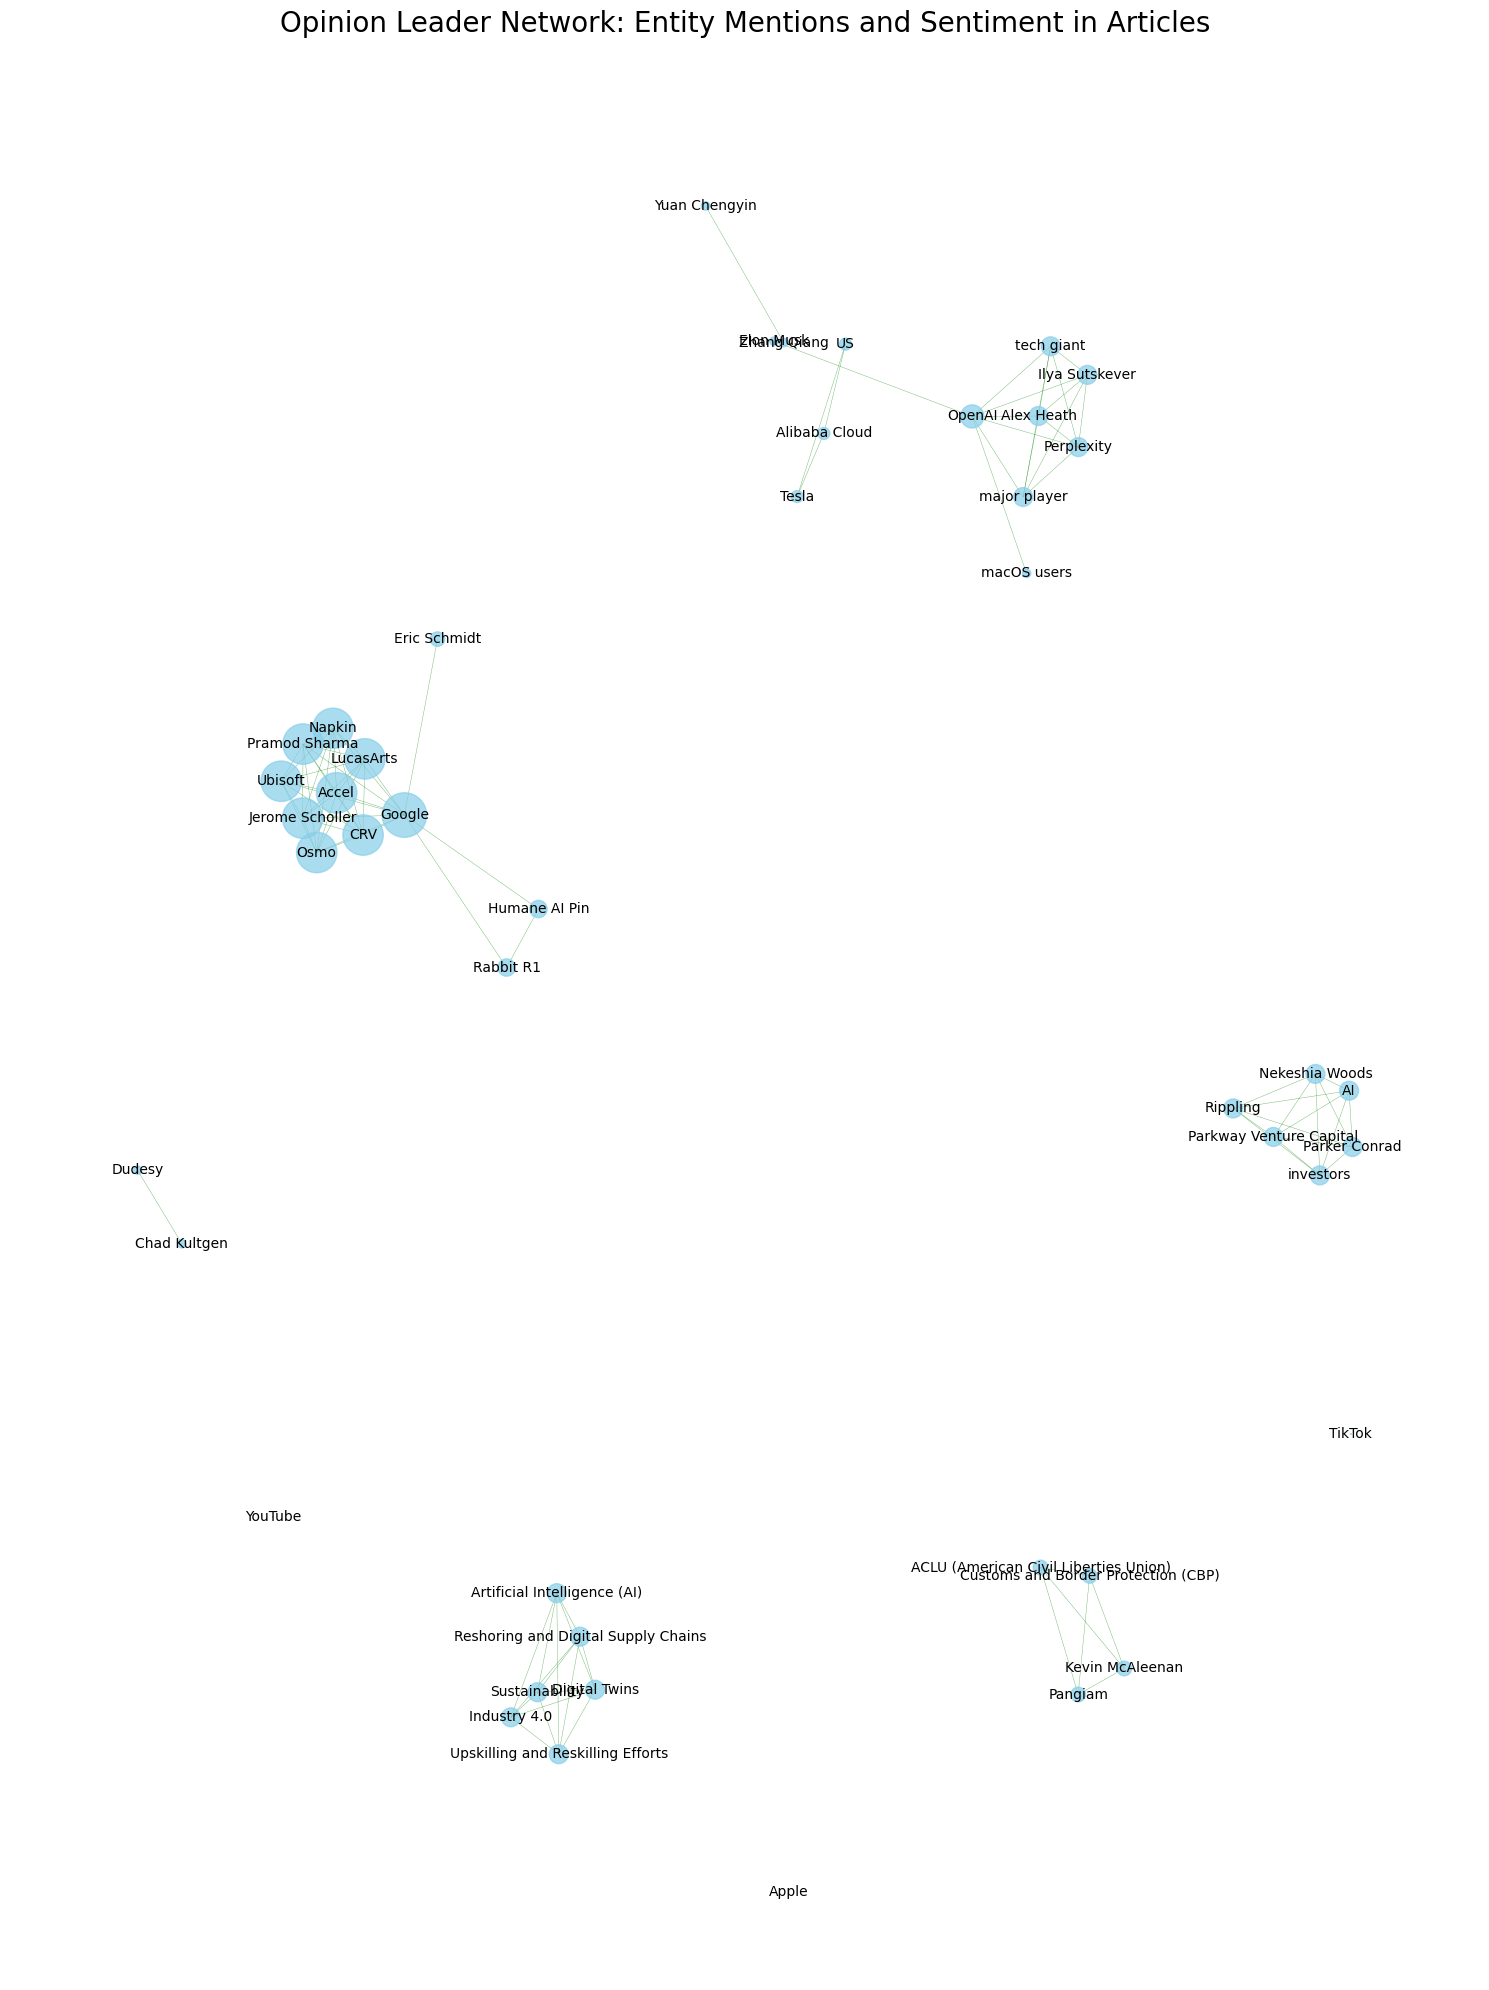

In [36]:
#Preparing visualization
print("\nPreparing visualization...")

#Defining node positions and layout
pos = nx.spring_layout(subgraph, k=0.3, iterations=50)

#Scaling node sizes by combined centrality scores
sizes = [combined_centrality[node] * 5000 for node in subgraph.nodes()]
labels = {node: node for node in subgraph.nodes()}

#Visualizing nodes and edges with sentiment-based attributes
plt.figure(figsize=(15, 20))
nx.draw_networkx_nodes(
    subgraph, pos, node_size=sizes, alpha=0.7, node_color='skyblue'
)

#Drawing edges with width based on sentiment score, and color according to sentiment
edge_colors = []
edge_widths = []
for u, v, data in subgraph.edges(data=True):
    sentiment = data.get('sentiment', 0.1)
    edge_widths.append(abs(sentiment) * 3 if sentiment else 1)
    edge_colors.append('green' if sentiment > 0 else 'red')

nx.draw_networkx_edges(
    subgraph, pos, width=edge_widths, edge_color=edge_colors, alpha=0.6
)

#Drawing labels for nodes
nx.draw_networkx_labels(subgraph, pos, labels, font_size=10, font_color='black')

#Adding a title and finalize layout
plt.title("Opinion Leader Network: Entity Mentions and Sentiment in Articles", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('opinion_leader_network_mentions.png', dpi=300, bbox_inches='tight')
plt.show()

#Printing results

In [28]:
#Printing top N entities (e.g., companies) by their combined centrality
print(f"\nTop {N} Entities by Combined Centrality:")
for entity, centrality in sorted_companies[:N]:
    print(f"{entity}: {centrality:.4f}")

#Calculating and printing the article distribution for top entities
article_distribution = defaultdict(lambda: defaultdict(int))

#Track mentions of each entity across articles in subgraph
for entity in top_companies:
    for article in B.neighbors(entity):
        article_distribution[entity][article] += 1

#Printing article topic distribution for top entities
print(f"\nArticle Mention Distribution for Top {N} Entities:")
for entity in top_companies:
    print(f"\n{entity}:")
    total = sum(article_distribution[entity].values())
    sorted_articles = sorted(article_distribution[entity].items(), key=lambda x: x[1], reverse=True)
    for article, count in sorted_articles:
        percentage = (count / total) * 100
        print(f"  {article}: {percentage:.2f}%")

#Saving centrality data for degree, betweenness, eigenvector, and combined centralities
centrality_data = {
    'degree': degree_centrality,
    'betweenness': betweenness_centrality,
    'eigenvector': eigenvector_centrality,
    'combined': combined_centrality
}

with open('entity_centralities.json', 'w', encoding='utf-8') as f:
    json.dump(centrality_data, f, ensure_ascii=False, indent=2)

print("\nCentrality data saved to 'entity_centralities.json'")


Top 75 Entities by Combined Centrality:
Google: 0.2056
Napkin: 0.1694
Pramod Sharma: 0.1694
Osmo: 0.1694
CRV: 0.1694
Accel: 0.1694
LucasArts: 0.1694
Jerome Scholler: 0.1694
Ubisoft: 0.1694
OpenAI: 0.0556
major player: 0.0370
Ilya Sutskever: 0.0370
Perplexity: 0.0370
tech giant: 0.0370
Alex Heath: 0.0370
Parkway Venture Capital: 0.0370
AI: 0.0370
Parker Conrad: 0.0370
investors: 0.0370
Rippling: 0.0370
Nekeshia Woods: 0.0370
Artificial Intelligence (AI): 0.0370
Sustainability: 0.0370
Industry 4.0: 0.0370
Reshoring and Digital Supply Chains: 0.0370
Upskilling and Reskilling Efforts: 0.0370
Digital Twins: 0.0370
Rabbit R1: 0.0312
Humane AI Pin: 0.0312
Kevin McAleenan: 0.0222
Pangiam: 0.0222
ACLU (American Civil Liberties Union): 0.0222
Customs and Border Protection (CBP): 0.0222
Eric Schmidt: 0.0217
US: 0.0148
Alibaba Cloud: 0.0148
Tesla: 0.0148
Elon Musk: 0.0074
macOS users: 0.0074
Zhang Qiang: 0.0074
Yuan Chengyin: 0.0074
Chad Kultgen: 0.0074
Dudesy: 0.0074
YouTube: 0.0000
Apple: 0.000